# Parameter estimation using ordinal data

This Notebook eplains the use of ordinal data for parameter estimation, as described in [Schmiester et al. (2019)](https://www.biorxiv.org/content/10.1101/848648v1.abstract). An example model is provided in `example_ordinal`

## Import model and create pyPESTO objective

In [65]:
import pypesto
import pypesto.petab
import pypesto.optimize as optimize

import amici
import petab
import numpy as np
from pypesto.hierarchical.optimal_scaling_approach.optimal_scaling_solver import OptimalScalingInnerSolver
import pypesto.logging
import logging

In [66]:
petab_folder = './example_ordinal/'
yaml_file = 'example_ordinal.yaml'

petab_problem = petab.Problem.from_yaml(petab_folder + yaml_file)

# To allow for optimization with ordinal measurements, set ordinal=True, when creating the importer
importer = pypesto.petab.PetabImporter(petab_problem, ordinal=True)

In [67]:
objective = importer.create_objective()
problem = importer.create_problem(objective)

engine = pypesto.engine.SingleCoreEngine()

optimizer = optimize.ScipyOptimizer(method='Nelder-Mead',
                                   options={'disp': True, 'maxiter': 500, 'maxfev': 500, 'fatol': 1e-10})
n_starts = 10
np.random.seed(n_starts)

## Run optimization using optimal scaling approach

Different options can be used for the optimal scaling approach:
- method: `standard` / `reduced`
- reparameterized: `True` / `False`
- intervalConstraints: `max` / `max-min`
- minGap: Any float value

It is recommended to use the reduced method with reparameterization as it is the most efficient and robust choice.

When no options are provided, the default is the reduced and reparameterized formulation with max as interval constraint and `minGap=1e-10`.

### Run optimization using the reduced and reparameterized approach

In [68]:
np.random.seed(n_starts)
problem.objective.calculator.inner_solver = OptimalScalingInnerSolver(options={'method': 'reduced',
                                                                               'reparameterized': True,
                                                                               'intervalConstraints': 'max',
                                                                               'minGap': 1e-10})

res_reduced_reparameterized = optimize.minimize(problem, n_starts=n_starts, optimizer=optimizer, engine=engine)

 10%|█         | 1/10 [00:02<00:25,  2.84s/it]

Optimization terminated successfully.
         Current function value: 0.000574
         Iterations: 146
         Function evaluations: 271


 20%|██        | 2/10 [00:03<00:14,  1.78s/it]

Optimization terminated successfully.
         Current function value: 0.000574
         Iterations: 48
         Function evaluations: 90


 30%|███       | 3/10 [00:05<00:12,  1.78s/it]

Optimization terminated successfully.
         Current function value: 0.000574
         Iterations: 90
         Function evaluations: 169


 40%|████      | 4/10 [00:06<00:07,  1.33s/it]

Optimization terminated successfully.
         Current function value: 0.001989
         Iterations: 36
         Function evaluations: 68


 50%|█████     | 5/10 [00:07<00:06,  1.22s/it]

Optimization terminated successfully.
         Current function value: 0.000574
         Iterations: 45
         Function evaluations: 91


 60%|██████    | 6/10 [00:08<00:05,  1.25s/it]

Optimization terminated successfully.
         Current function value: 0.000574
         Iterations: 58
         Function evaluations: 109


 70%|███████   | 7/10 [00:10<00:03,  1.30s/it]

Optimization terminated successfully.
         Current function value: 0.000574
         Iterations: 68
         Function evaluations: 132


 80%|████████  | 8/10 [00:11<00:02,  1.26s/it]

Optimization terminated successfully.
         Current function value: 0.000574
         Iterations: 54
         Function evaluations: 102


 90%|█████████ | 9/10 [00:12<00:01,  1.35s/it]

Optimization terminated successfully.
         Current function value: 0.000574
         Iterations: 81
         Function evaluations: 147


100%|██████████| 10/10 [00:14<00:00,  1.40s/it]

Optimization terminated successfully.
         Current function value: 0.000574
         Iterations: 60
         Function evaluations: 110


### Run optimization using the reduced non-reparameterized approach

In [69]:
np.random.seed(n_starts)
problem.objective.calculator.inner_solver = OptimalScalingInnerSolver(options={'method': 'reduced',
                                                                               'reparameterized': False,
                                                                               'intervalConstraints': 'max',
                                                                               'minGap': 1e-10})

res_reduced = optimize.minimize(problem, n_starts=n_starts, optimizer=optimizer, engine=engine)

 10%|█         | 1/10 [00:02<00:22,  2.46s/it]

Optimization terminated successfully.
         Current function value: 0.000574
         Iterations: 134
         Function evaluations: 247


 20%|██        | 2/10 [00:03<00:12,  1.58s/it]

Optimization terminated successfully.
         Current function value: 0.000574
         Iterations: 46
         Function evaluations: 85


 30%|███       | 3/10 [00:05<00:11,  1.68s/it]

Optimization terminated successfully.
         Current function value: 0.000574
         Iterations: 90
         Function evaluations: 169


 40%|████      | 4/10 [00:05<00:07,  1.26s/it]

Optimization terminated successfully.
         Current function value: 0.001989
         Iterations: 36
         Function evaluations: 68


 50%|█████     | 5/10 [00:06<00:05,  1.17s/it]

Optimization terminated successfully.
         Current function value: 0.000574
         Iterations: 45
         Function evaluations: 91


 60%|██████    | 6/10 [00:08<00:05,  1.30s/it]

Optimization terminated successfully.
         Current function value: 0.000574
         Iterations: 69
         Function evaluations: 133


 70%|███████   | 7/10 [00:09<00:04,  1.34s/it]

Optimization terminated successfully.
         Current function value: 0.000574
         Iterations: 69
         Function evaluations: 132


 80%|████████  | 8/10 [00:11<00:02,  1.29s/it]

Optimization terminated successfully.
         Current function value: 0.000574
         Iterations: 54
         Function evaluations: 102


 90%|█████████ | 9/10 [00:12<00:01,  1.38s/it]

Optimization terminated successfully.
         Current function value: 0.000574
         Iterations: 81
         Function evaluations: 147


100%|██████████| 10/10 [00:13<00:00,  1.39s/it]

Optimization terminated successfully.
         Current function value: 0.000574
         Iterations: 60
         Function evaluations: 110


### Run optimization using the standard approach

In [70]:
np.random.seed(n_starts)
problem.objective.calculator.inner_solver = OptimalScalingInnerSolver(options={'method': 'standard',
                                                                               'reparameterized': False,
                                                                               'intervalConstraints': 'max',
                                                                               'minGap': 1e-10})

res_standard = optimize.minimize(problem, n_starts=n_starts, optimizer=optimizer, engine=engine)

 10%|█         | 1/10 [00:02<00:23,  2.63s/it]

Optimization terminated successfully.
         Current function value: 0.000574
         Iterations: 126
         Function evaluations: 229


 20%|██        | 2/10 [00:03<00:13,  1.71s/it]

Optimization terminated successfully.
         Current function value: 0.000574
         Iterations: 46
         Function evaluations: 85


 30%|███       | 3/10 [00:05<00:12,  1.80s/it]

Optimization terminated successfully.
         Current function value: 0.000574
         Iterations: 87
         Function evaluations: 162


 40%|████      | 4/10 [00:06<00:08,  1.36s/it]

Optimization terminated successfully.
         Current function value: 0.001989
         Iterations: 36
         Function evaluations: 68


 50%|█████     | 5/10 [00:07<00:06,  1.29s/it]

Optimization terminated successfully.
         Current function value: 0.000574
         Iterations: 47
         Function evaluations: 96


 60%|██████    | 6/10 [00:09<00:05,  1.39s/it]

Optimization terminated successfully.
         Current function value: 0.000574
         Iterations: 67
         Function evaluations: 123


 70%|███████   | 7/10 [00:10<00:04,  1.46s/it]

Optimization terminated successfully.
         Current function value: 0.000574
         Iterations: 69
         Function evaluations: 134


 80%|████████  | 8/10 [00:11<00:02,  1.39s/it]

Optimization terminated successfully.
         Current function value: 0.000574
         Iterations: 52
         Function evaluations: 100


 90%|█████████ | 9/10 [00:13<00:01,  1.47s/it]

Optimization terminated successfully.
         Current function value: 0.000574
         Iterations: 78
         Function evaluations: 143


100%|██████████| 10/10 [00:15<00:00,  1.50s/it]

Optimization terminated successfully.
         Current function value: 0.000574
         Iterations: 63
         Function evaluations: 119


### Compare results

Reduced formulation leads to improved computation times

In [71]:
time_standard = res_standard.optimize_result.get_for_key('time')
print(f"Mean computation time for standard approach: {np.mean(time_standard)}")

time_reduced = res_reduced.optimize_result.get_for_key('time')
print(f"Mean computation time for reduced approach: {np.mean(time_reduced)}")

time_reduced_reparameterized = res_reduced_reparameterized.optimize_result.get_for_key('time')
print(f"Mean computation time for reduced reparameterized approach: {np.mean(time_reduced_reparameterized)}")

Mean computation time for standard approach: 1.5030477523803711
Mean computation time for reduced approach: 1.3862767934799194
Mean computation time for reduced reparameterized approach: 1.404467272758484


All approaches yield the same objective function values

<AxesSubplot: title={'center': 'Waterfall plot'}, xlabel='Ordered optimizer run', ylabel='Objective value (offset=9.994e-01)'>

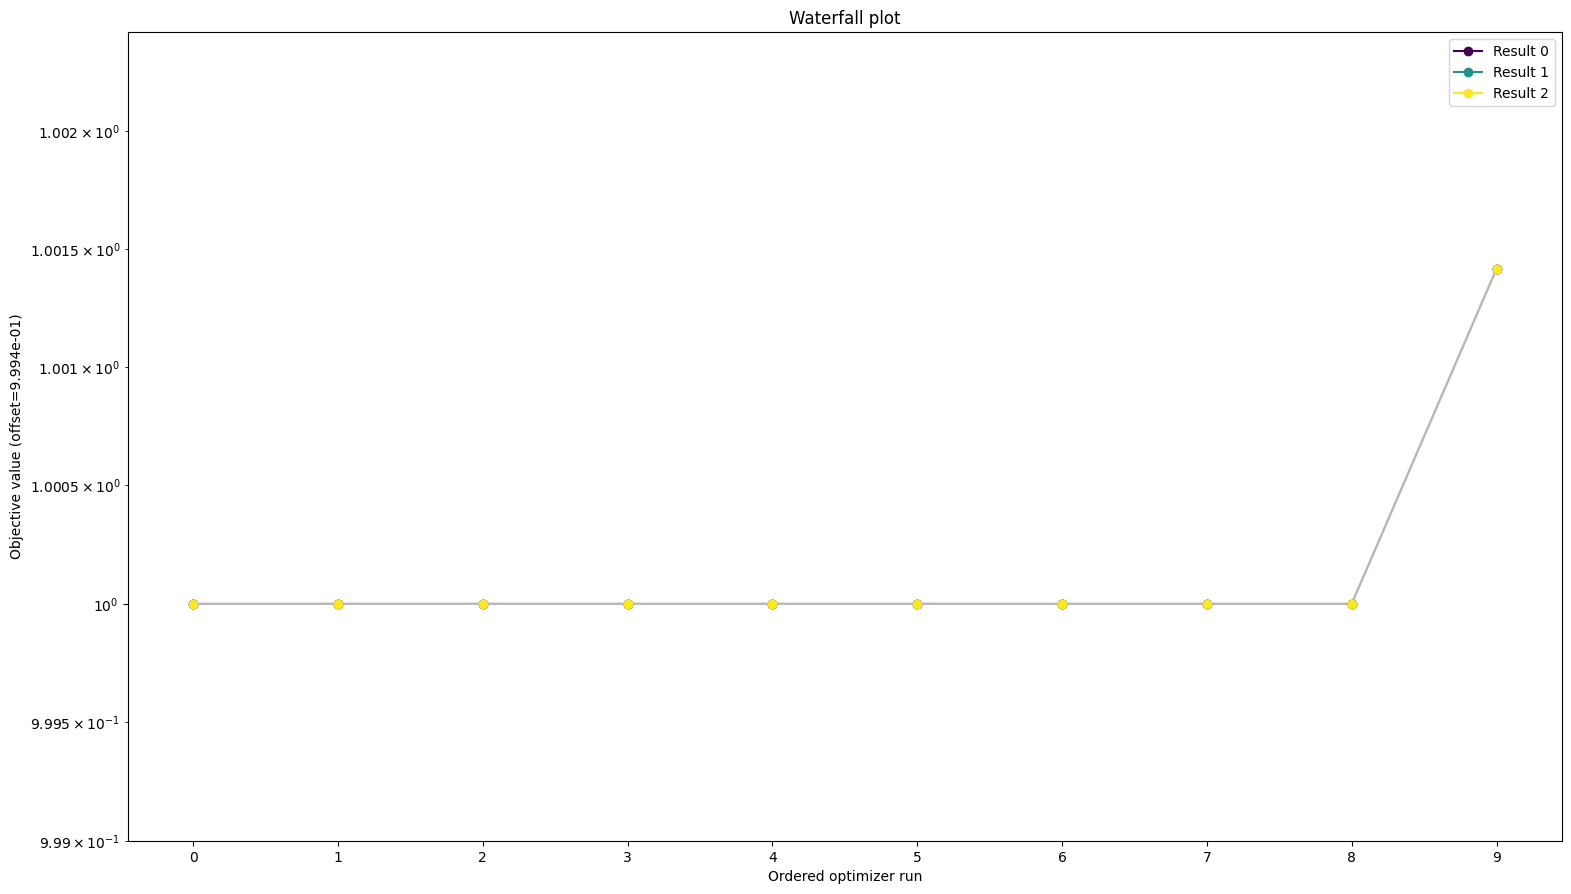

In [72]:
from pypesto.visualize import waterfall

waterfall([res_standard, res_reduced, res_reduced_reparameterized])

## Gradient-based optimization
To use the optimal scaling method with a gradient-based optimizer, the only change is in the optimizer used:

In [73]:
optimizer = optimize.ScipyOptimizer(
    method="L-BFGS-B",
    options={"disp": None, "ftol": 2.220446049250313e-09, "gtol": 1e-5},
)

### Running optimization with a gradient-based optimizer

In [74]:
np.random.seed(n_starts)
problem.objective.calculator.inner_solver = OptimalScalingInnerSolver(options={'method': 'reduced',
                                                                               'reparameterized': True,
                                                                               'intervalConstraints': 'max',
                                                                               'minGap': 1e-10})

grad_res_reduced_reparameterized = optimize.minimize(problem, n_starts=n_starts, optimizer=optimizer, engine=engine)

100%|██████████| 10/10 [00:08<00:00,  1.19it/s]


In [75]:
np.random.seed(n_starts)
problem.objective.calculator.inner_solver = OptimalScalingInnerSolver(options={'method': 'reduced',
                                                                               'reparameterized': False,
                                                                               'intervalConstraints': 'max',
                                                                               'minGap': 1e-10})

grad_res_reduced = optimize.minimize(problem, n_starts=n_starts, optimizer=optimizer, engine=engine)

100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


In [76]:
np.random.seed(n_starts)
problem.objective.calculator.inner_solver = OptimalScalingInnerSolver(options={'method': 'standard',
                                                                               'reparameterized': False,
                                                                               'intervalConstraints': 'max',
                                                                               'minGap': 1e-10})

grad_res_standard = optimize.minimize(problem, n_starts=n_starts, optimizer=optimizer, engine=engine)

100%|██████████| 10/10 [00:08<00:00,  1.13it/s]


### Compare results

Reduced formulation leads to improved computation times

In [77]:
grad_time_standard = grad_res_standard.optimize_result.get_for_key('time')
print(f"Mean computation time for gradient-based standard approach: {np.mean(grad_time_standard)}")

grad_time_reduced = grad_res_reduced.optimize_result.get_for_key('time')
print(f"Mean computation time for gradient-based reduced approach: {np.mean(grad_time_reduced)}")

grad_time_reduced_reparameterized = grad_res_reduced_reparameterized.optimize_result.get_for_key('time')
print(f"Mean computation time for gradient-based reduced reparameterized approach: {np.mean(grad_time_reduced_reparameterized)}")

Mean computation time for gradient-based standard approach: 0.8808380365371704
Mean computation time for gradient-based reduced approach: 0.8463656187057496
Mean computation time for gradient-based reduced reparameterized approach: 0.841195797920227


All approaches yield the same objective function values.

<AxesSubplot: title={'center': 'Waterfall plot'}, xlabel='Ordered optimizer run', ylabel='Objective value (offset=9.994e-01)'>

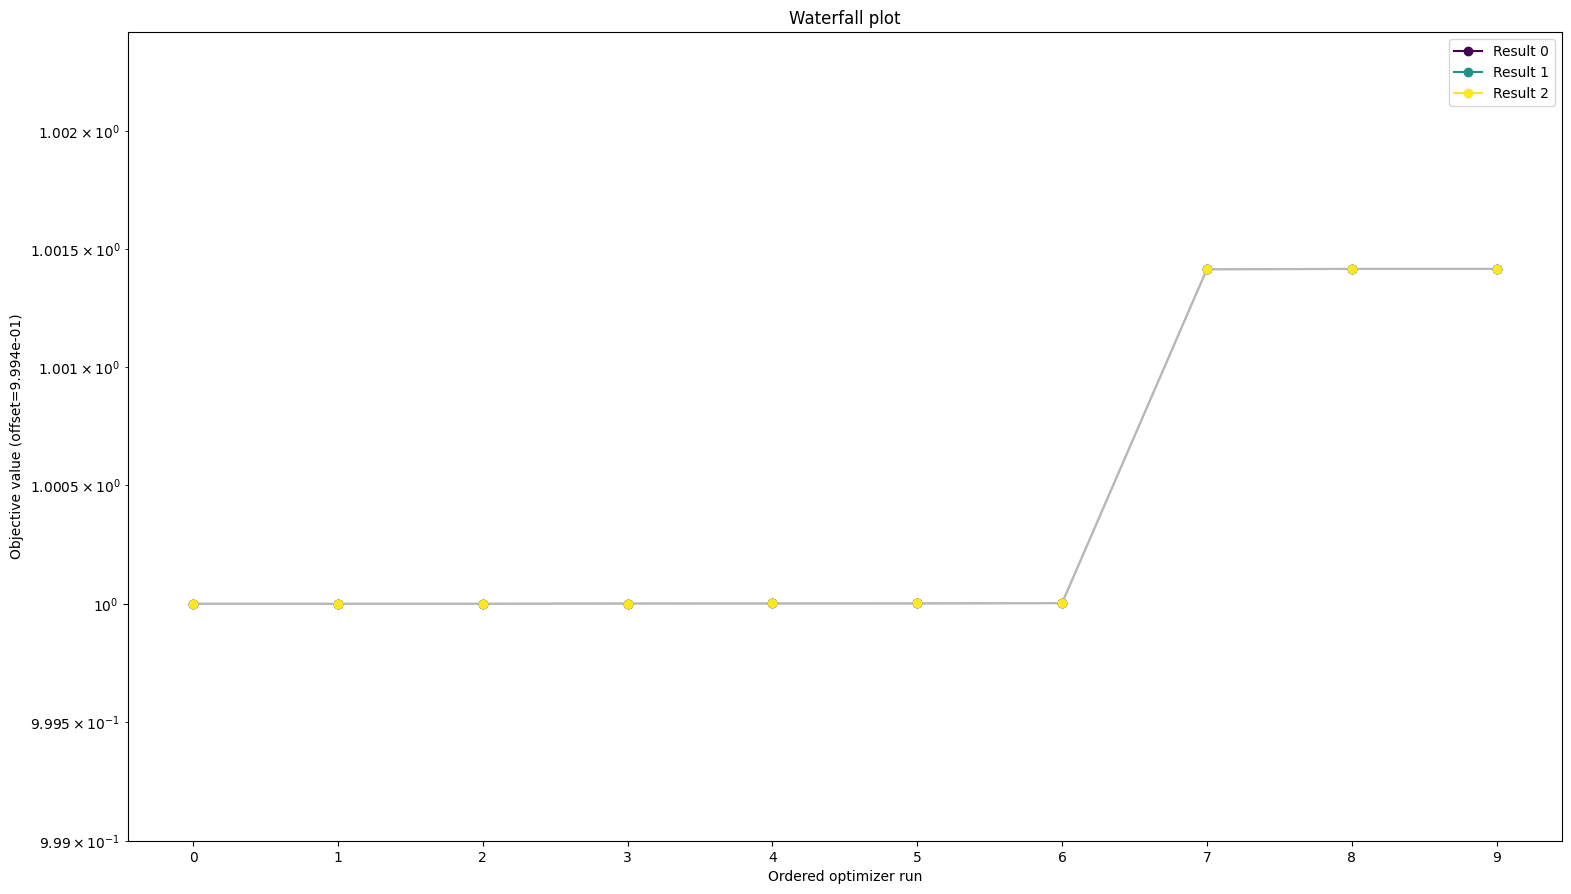

In [78]:
waterfall([grad_res_standard, grad_res_reduced, grad_res_reduced_reparameterized])